In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from io import StringIO
import re

import numpy as np
import pandas as pd


def parse_levels(log):
    def convert_to_float64(x):
        if isinstance(x, str) and x.strip() == "inf":
            return np.float64("inf")
        try:
            return np.float64(x)
        except Exception as e:
            raise e

    def _get_df(data):
        dtypes = {
            "DIAGNOSTIC": str,
            "Iteration": np.uint64,
            "metricValue": np.float64,
            "convergenceValue": np.float64,
            "ITERATION_TIME_INDEX": np.float64,
            "SINCE_LAST": np.float64,
        }

        return pd.read_csv(
            StringIO(data),
            sep=",",
            usecols=[0, 1, 2, 3, 4, 5],
            names=dtypes.keys(),
            dtype=dtypes,
            converters={"convergenceValue": convert_to_float64},
        )

    return [
        _get_df(x)
        for x in re.split(
            r"(XX)?DIAGNOSTIC,Iteration,metricValue,convergenceValue,ITERATION_TIME_INDEX,SINCE_LAST",
            log.strip(),
        )
        if x not in [None, "", "XX"]
    ]


def get_level_stats(level):
    return {
        "n_iter": len(level),
        "time": level["SINCE_LAST"].sum(),
        "time_mean": level["SINCE_LAST"].mean(),
        "time_std": level["SINCE_LAST"].std(),
        "time_min": level["SINCE_LAST"].min(),
        "time_max": level["SINCE_LAST"].max(),
        "metricValue_start": level["metricValue"].iloc[0],
        "metricValue_end": level["metricValue"].iloc[-1],
        "convergenceValue_start": level["convergenceValue"].iloc[0],
        "convergenceValue_end": level["convergenceValue"].iloc[-1],
    }

In [3]:
def parse_stage(snippet):
    return {"name": snippet[0], "levels": parse_levels(snippet[1]), "time": snippet[3]}

In [4]:
from collections import defaultdict


def get_pipeline_data(files):
    # [stage-level, [stat, value]]
    pipeline_data = defaultdict(lambda: defaultdict(list))
    p = re.compile(r"(\*\*\* .* \*\*\*)((\n|.)*?)Elapsed time \(stage \d\): (.*)")
    STAGE_NAME = ["Euler3DTransform", "AffineTransform", "SyN registration"]

    for file in files.values():
        for i, stage in enumerate(p.findall(file.read_text())):
            stage_data = parse_stage(stage)
            for j, level in enumerate(stage_data["levels"]):
                for stat, value in get_level_stats(level).items():
                    pipeline_data[f"{STAGE_NAME[i]} - level #{j}"][stat].append(value)

    return pipeline_data

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pipelines_stat(pipelines_data, /, *, target, y_label):
    stages = pipelines_data["single"].keys()

    def get_stats(data, target):
        mean = []
        std = []
        for _, stats in data.items():
            mean.append(np.array(stats[target]).mean())
            std.append(np.array(stats[target]).std())

        return {
            "mean": np.array(mean),
            "std": np.array(std),
        }

    stats = {pipeline: get_stats(data, target) for pipeline, data in pipelines_data.items()}

    x = np.arange(len(stages))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout="constrained", figsize=(16,9)
    )

    max_y = -float("inf")
    for label, stat in stats.items():
        offset = width * multiplier
        r = ax.bar(x + offset, stat["mean"], yerr=stat["std"], width=width, label=label)
        ax.bar_label(r, padding=3, rotation=90)

        multiplier += 1
        max_y = max(max_y, (stat["mean"] + stat["std"]).max())

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title("ANTS registrationSyN convergence analysis")
    ax.set_xticks(x + width/len(stats), stages)
    ax.legend(loc="upper left", ncols=len(stages))
    ax.set_ylim(0, max_y * 1.1)
    plt.xticks(rotation=90)

    plt.show()

# 1 Thread

In [6]:
from pathlib import Path
import re

log_dir = Path("/home/mathdugre/papers/neuro-bottleneck/ants_log-1thread")
pipeline = "registrationSyN"

p = re.compile(r"(?P<log_id>\d+)\.out")

single: dict[int, str] = dict()
double: dict[int, str] = dict()
for filename in log_dir.glob(f"ants-{pipeline}-*.out"):
    m = p.search(filename.as_posix())
    log_id = m.groupdict()["log_id"]

    if "-fp-" in filename.name:
        single[log_id] = filename
    else:
        double[log_id] = filename

In [7]:
pipelines_data = {
    "single": get_pipeline_data(single),
    "double": get_pipeline_data(double),
}

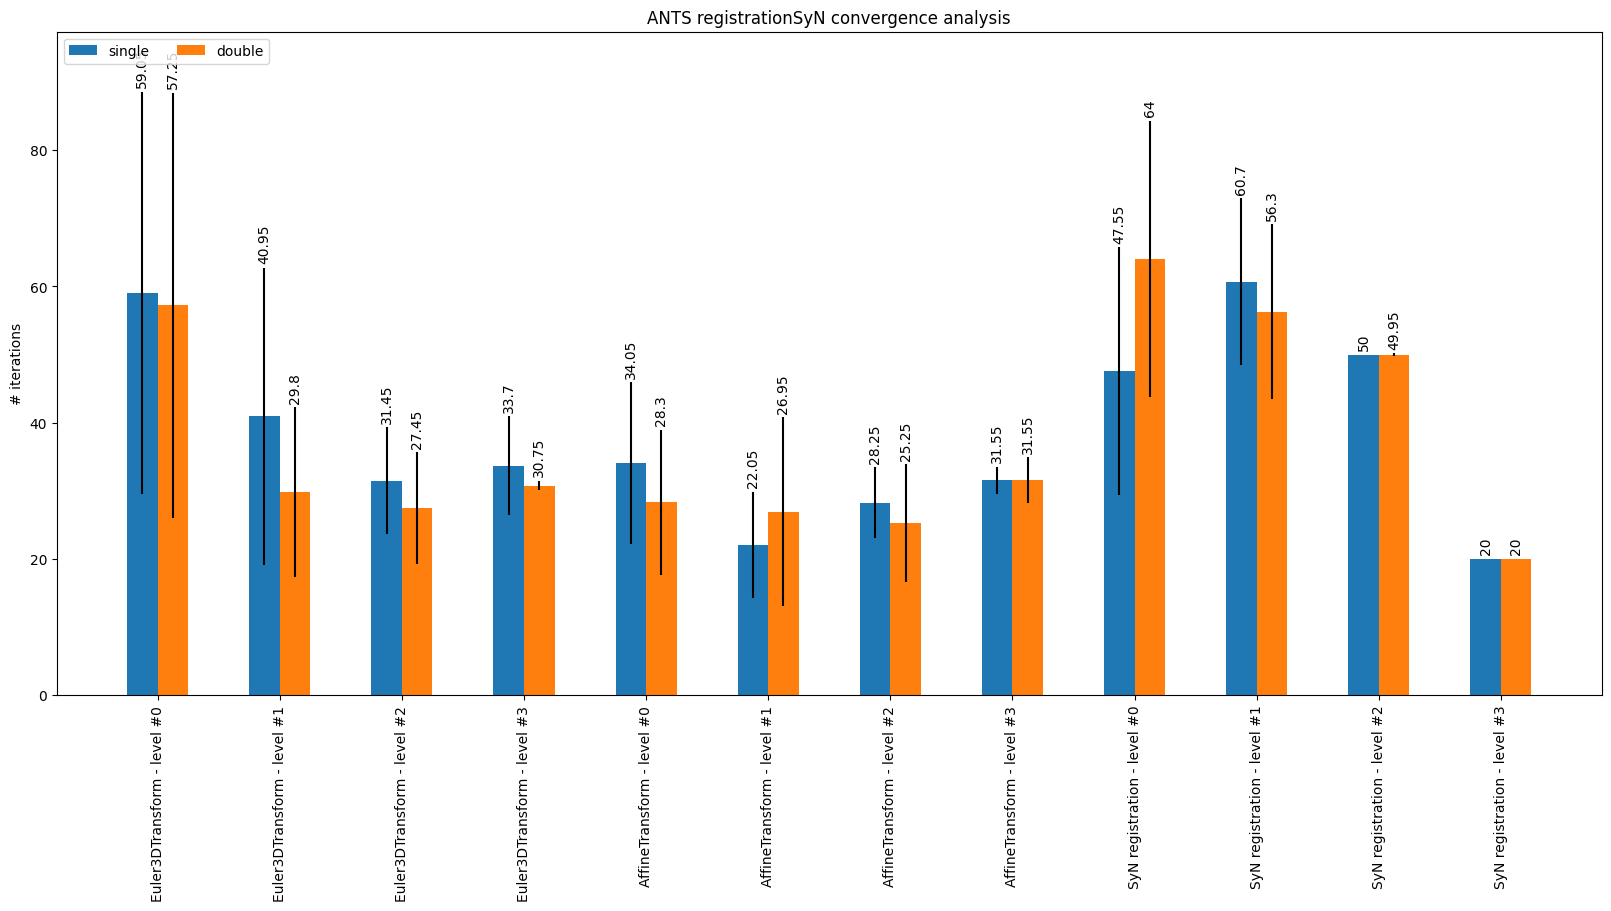

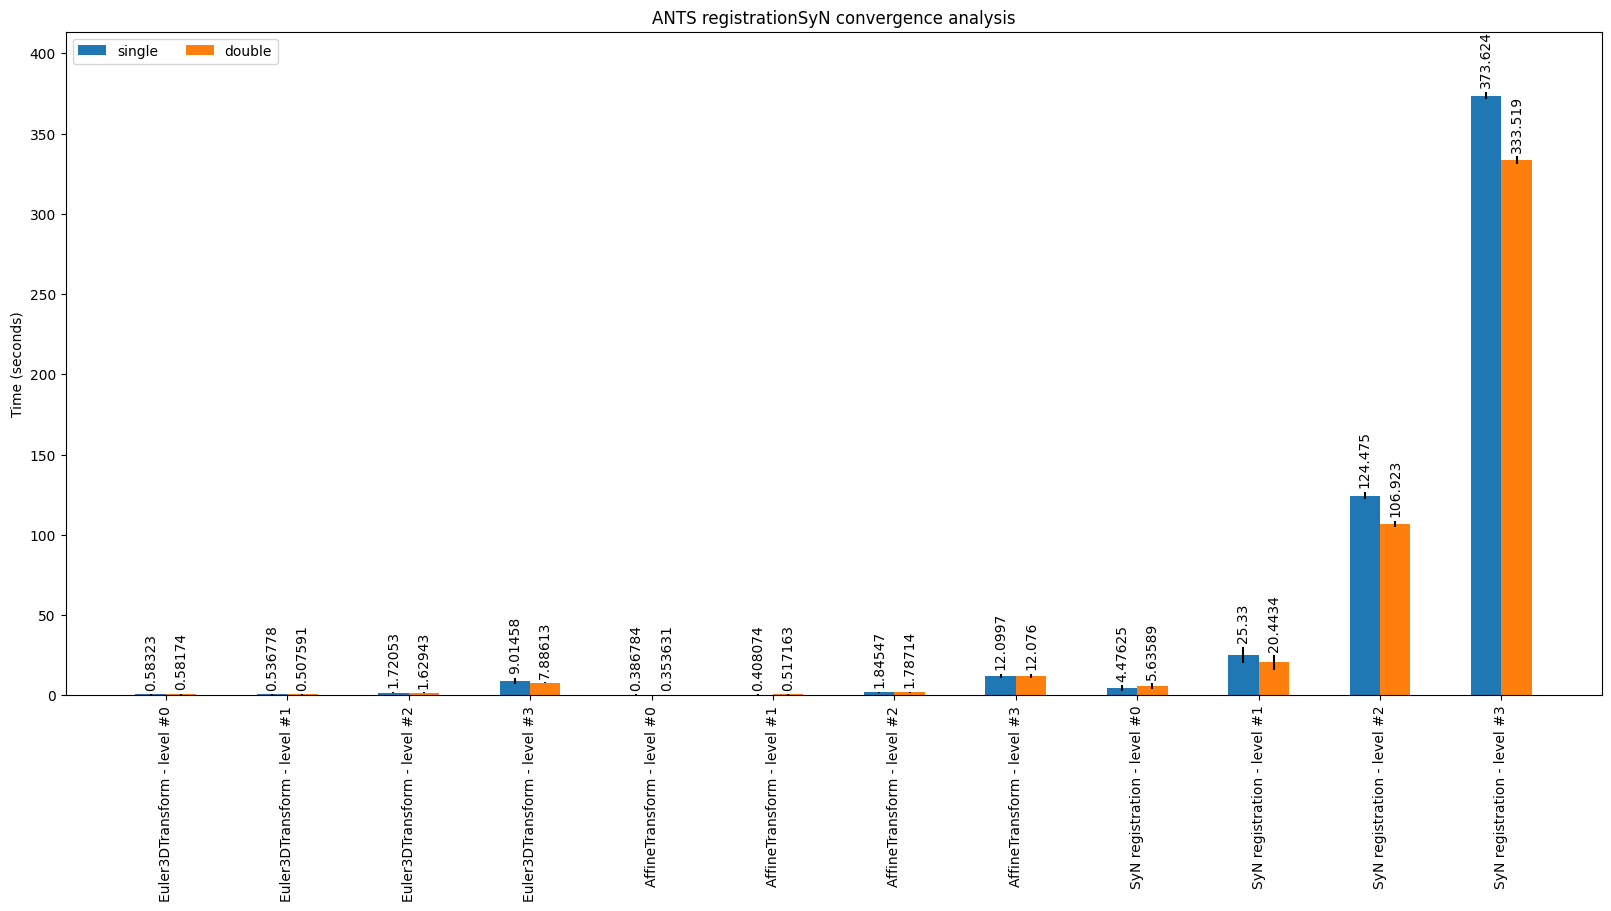

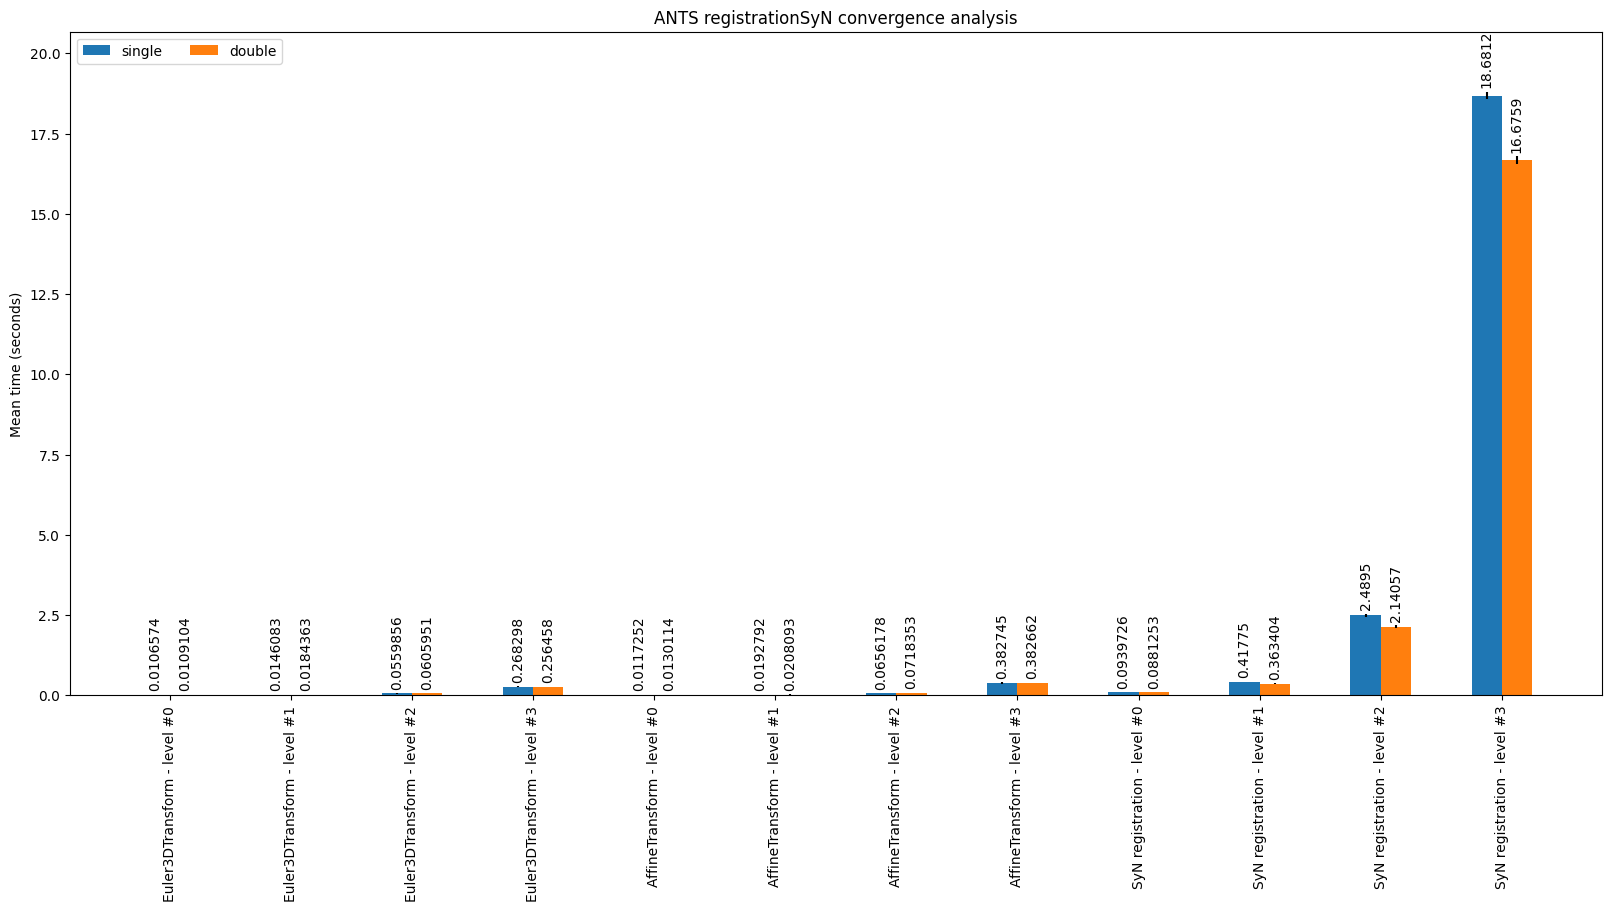

In [12]:
plot_pipelines_stat(pipelines_data, target="n_iter", y_label="# iterations")
plot_pipelines_stat(pipelines_data, target="time", y_label="Time (seconds)")
plot_pipelines_stat(pipelines_data, target="time_mean", y_label="Mean time (seconds)")

# 32 Thread

In [9]:
from pathlib import Path
import re

log_dir = Path("/home/mathdugre/papers/neuro-bottleneck/ants_log-32thread")
pipeline = "registrationSyN"

p = re.compile(r"(?P<log_id>\d+)\.out")

single: dict[int, str] = dict()
double: dict[int, str] = dict()
for filename in log_dir.glob(f"ants-{pipeline}-*.out"):
    m = p.search(filename.as_posix())
    log_id = m.groupdict()["log_id"]

    if "-fp-" in filename.name:
        single[log_id] = filename
    else:
        double[log_id] = filename

In [10]:
pipelines_data = {
    "single": get_pipeline_data(single),
    "double": get_pipeline_data(double),
}

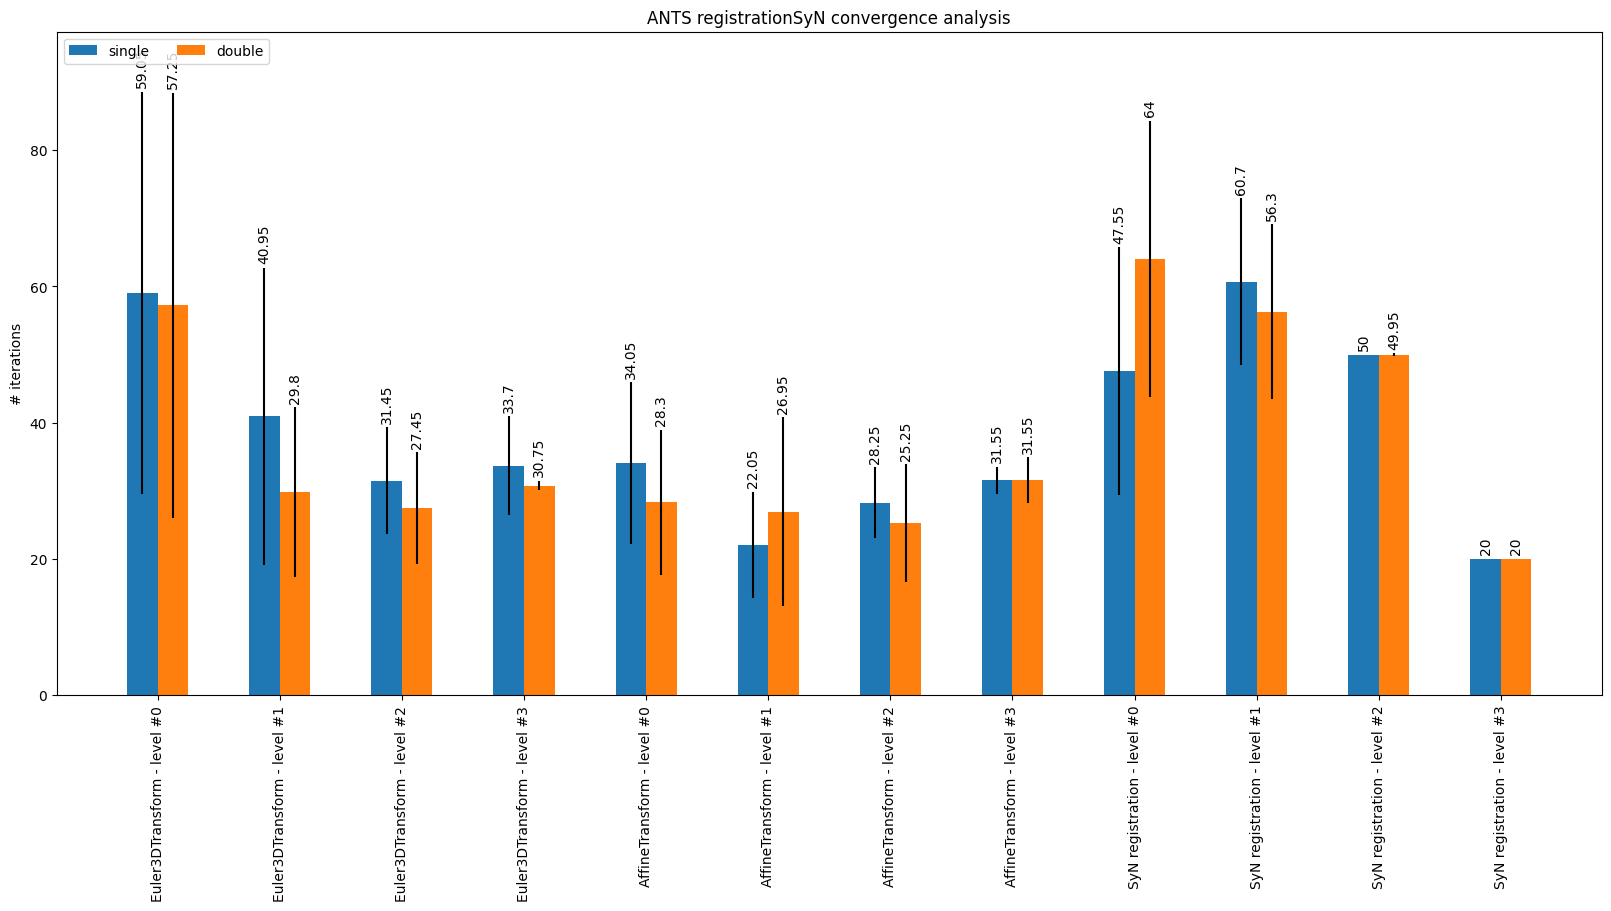

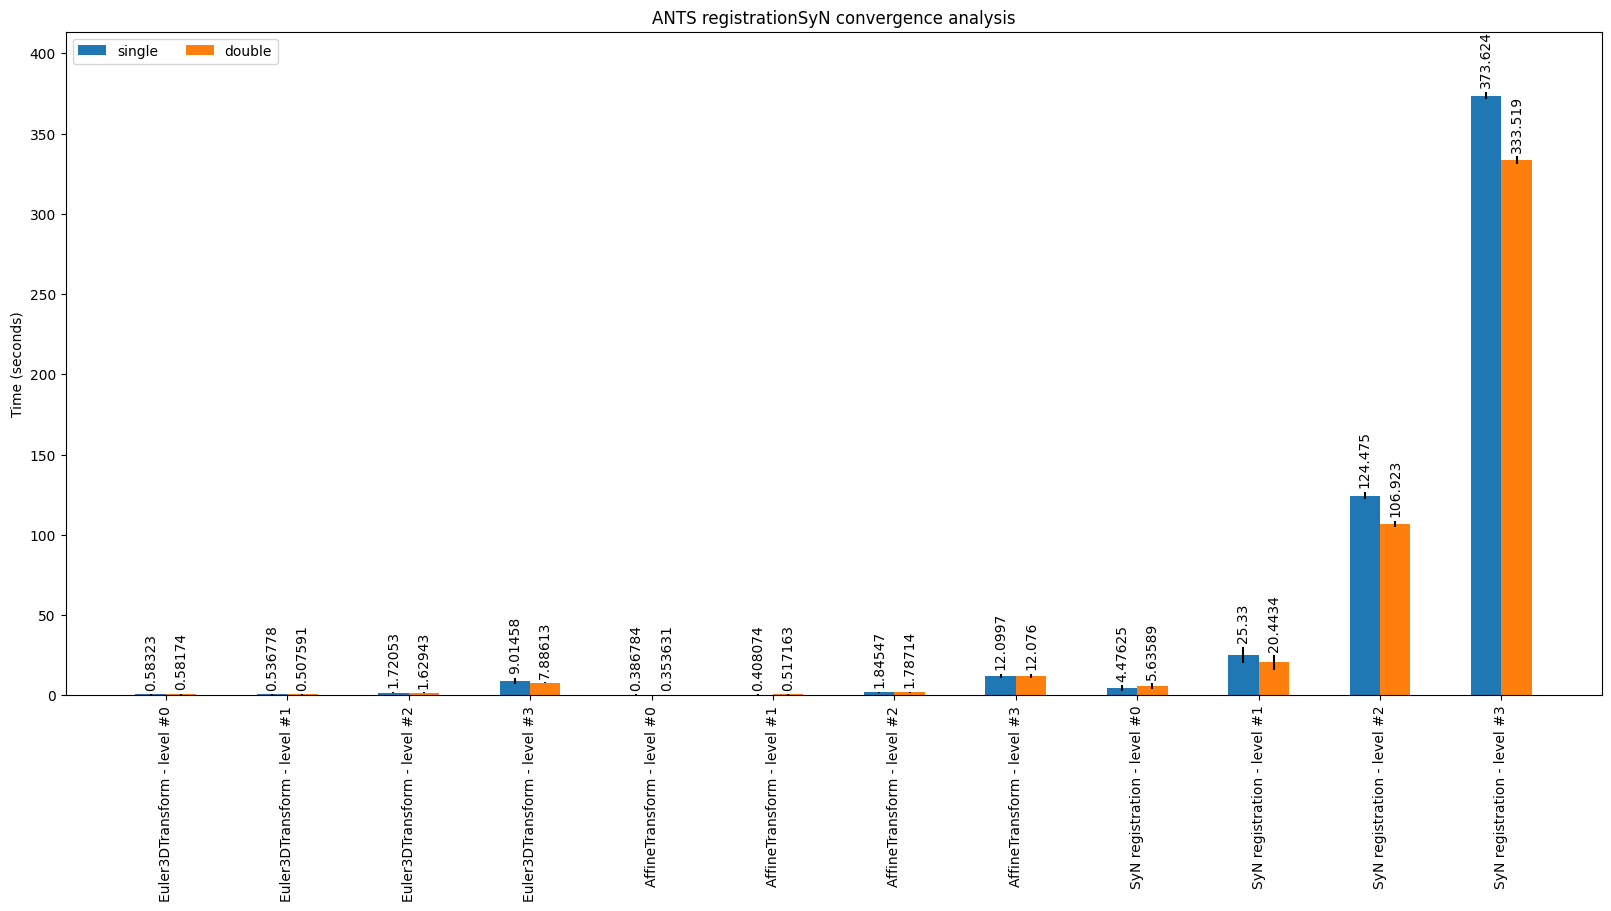

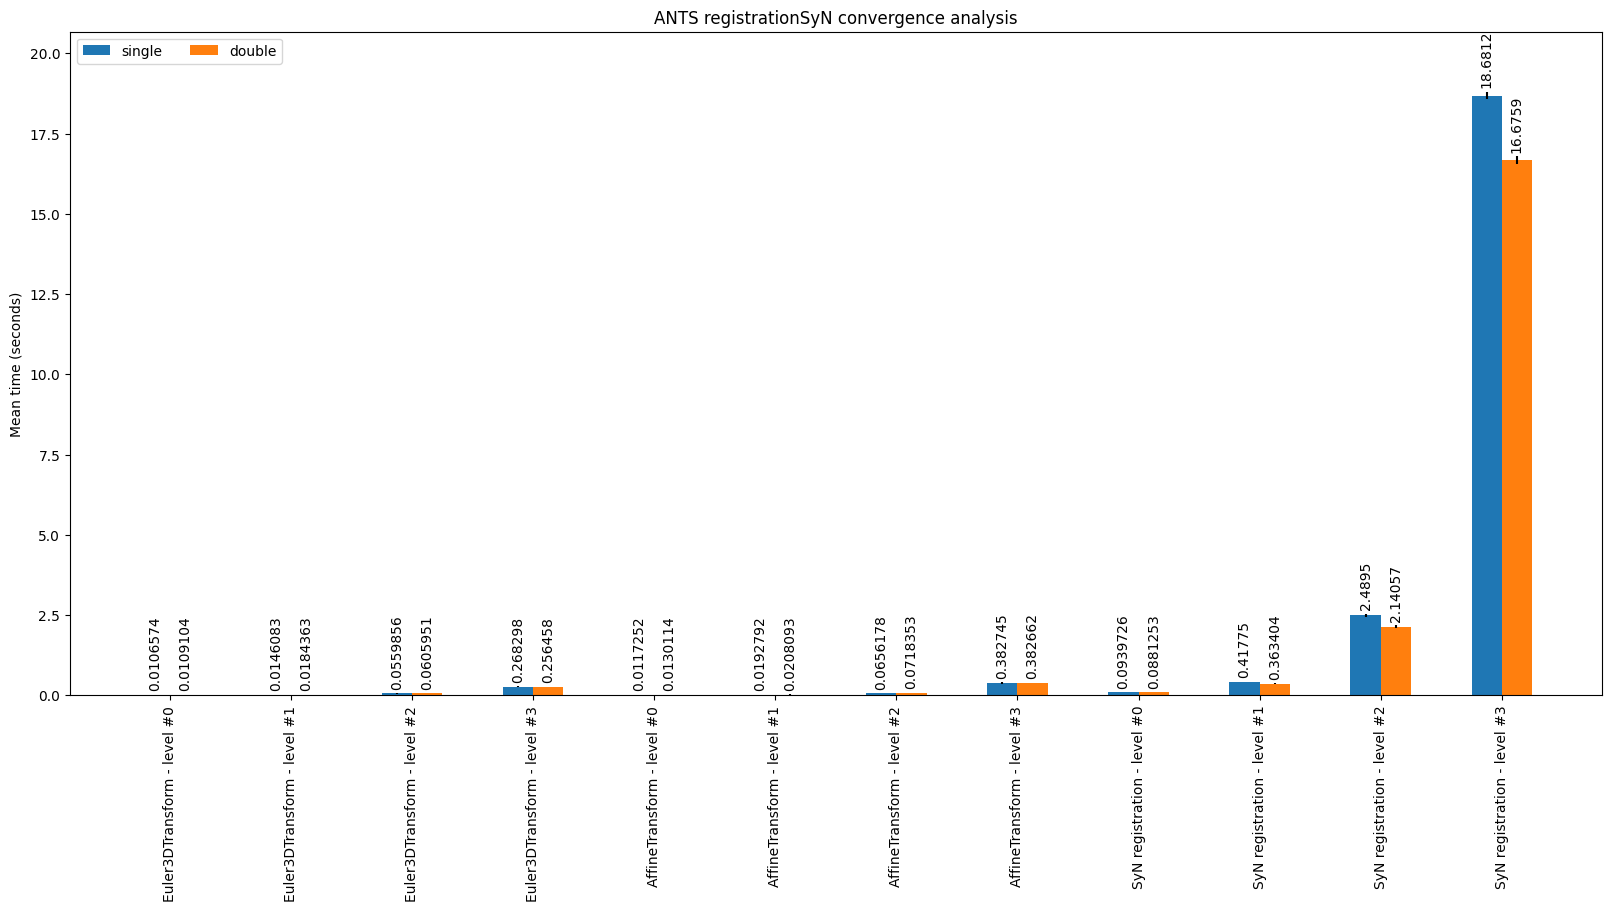

In [13]:
plot_pipelines_stat(pipelines_data, target="n_iter", y_label="# iterations")
plot_pipelines_stat(pipelines_data, target="time", y_label="Time (seconds)")
plot_pipelines_stat(pipelines_data, target="time_mean", y_label="Mean time (seconds)")